In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['i do not know what you think father whispered the princess',
 'with his podgy old hands resting symmetrically on its arms at the sound',
 '',
 'a shot and our troops could be seen hurrying to the crossing',
 'a group of undertakers who hid whenever a carriage drove up waited in',
 'with his face buried in the ground and a blackened nape lay on his',
 'but i wish it he said i beg yougive it him',
 '',
 '',
 'worth thinking or speaking of it at such a moment at a time of such']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.8526, -0.5552,  1.1134,  ...,  1.0287, -0.4094,  1.0918],
        [-0.6218, -1.1835,  2.1328,  ..., -0.0079, -0.0603,  0.7320],
        [-0.2552,  1.6611,  0.2768,  ..., -0.4951, -0.4578, -0.3702],
        ...,
        [ 0.7285,  1.4275, -0.1498,  ...,  0.0184,  0.7694, -0.6787],
        [-1.2921,  0.5810, -0.2014,  ...,  0.1592, -0.9600, -0.7020],
        [-1.9241,  0.9293,  0.8364,  ..., -1.0418, -0.1761,  0.0846]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_31/64346145.py line 8 
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 16:30:25.924000 135803339568960 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/s

 camlet bilibin like keenness sterne feels complacent brings eventuality touchedi my shyly proceed hatest stable stralsund possessor darent podgy aching painstaking ironical pass begill fussy patients door broadshouldered youngest yielding enduring random playful methods repented pomade cogwheels austere establishing ilya bespattered produce occasionally cards heartwatching flings arent surveyed arouse war cautious cloak turn incredible venture bend weported essential reticule discovery duke slaveslafe tree butts herculean elegant look name who result countrymen modern wearied attraction resignation brief flopped kindled adoring stands ilarionovich received level spots added dozen entreaty mistaking nursemaids cottage nearest piercingly shirts concentrated resistance positively annette obvious wetted greeted
 crimson spasski nightshirt brilliant imagine advice hasty pupilsi shadows greedily fulfill y inflict miniature spots letting crawled modestly expense never venal couch groom stern

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([512, 256])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

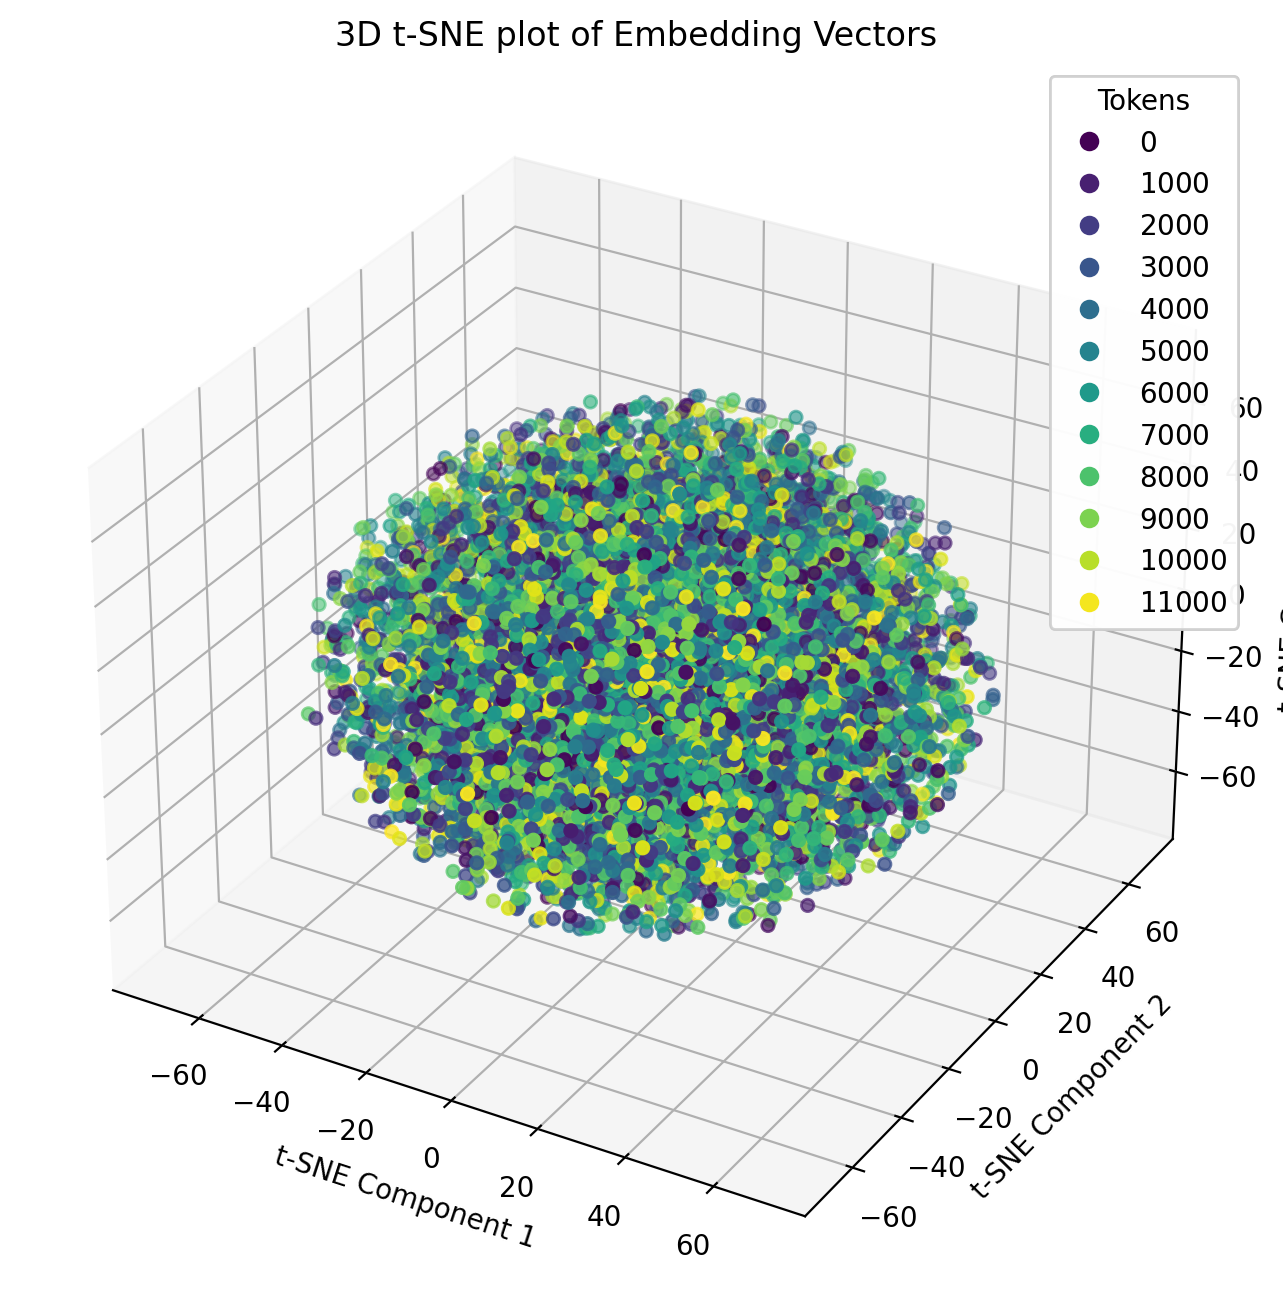

In [16]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [22]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(500):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 2.6612660884857178
Epoch 10, Loss: 2.5893993377685547
Epoch 20, Loss: 2.568355083465576
Epoch 30, Loss: 2.550182342529297
Epoch 40, Loss: 2.5331833362579346
Epoch 50, Loss: 2.5169966220855713
Epoch 60, Loss: 2.5014612674713135
Epoch 70, Loss: 2.4864673614501953
Epoch 80, Loss: 2.4719762802124023
Epoch 90, Loss: 2.457883834838867
Epoch 100, Loss: 2.444328784942627
Epoch 110, Loss: 2.4311792850494385
Epoch 120, Loss: 2.418524742126465
Epoch 130, Loss: 2.4062294960021973
Epoch 140, Loss: 2.3943376541137695
Epoch 150, Loss: 2.382716178894043
Epoch 160, Loss: 2.371560573577881
Epoch 170, Loss: 2.360678195953369
Epoch 180, Loss: 2.3499746322631836
Epoch 190, Loss: 2.33965802192688
Epoch 200, Loss: 2.3295516967773438
Epoch 210, Loss: 2.3197665214538574
Epoch 220, Loss: 2.310269832611084
Epoch 230, Loss: 2.3009910583496094
Epoch 240, Loss: 2.2919492721557617
Epoch 250, Loss: 2.2831506729125977
Epoch 260, Loss: 2.2745206356048584
Epoch 270, Loss: 2.2662484645843506
Epoch 280, Los

In [24]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 thats true that either meddling the first moment no my part also
 indicate the lines of oftener was visible able to
 intending and ceaselessly you she added to speak that once wanted to
 bathhouse of himself although is not very much and why there are fear
 this young men happy came out on his right was
 the icons of his views was changed as possible had
 god
 motionless made her social son ah god knows his small
 by anna pavlovna evidently felt something to be a russian officer
 the action balls of her destroying the horse went the short came up and sitting down under dolokhovs arms and


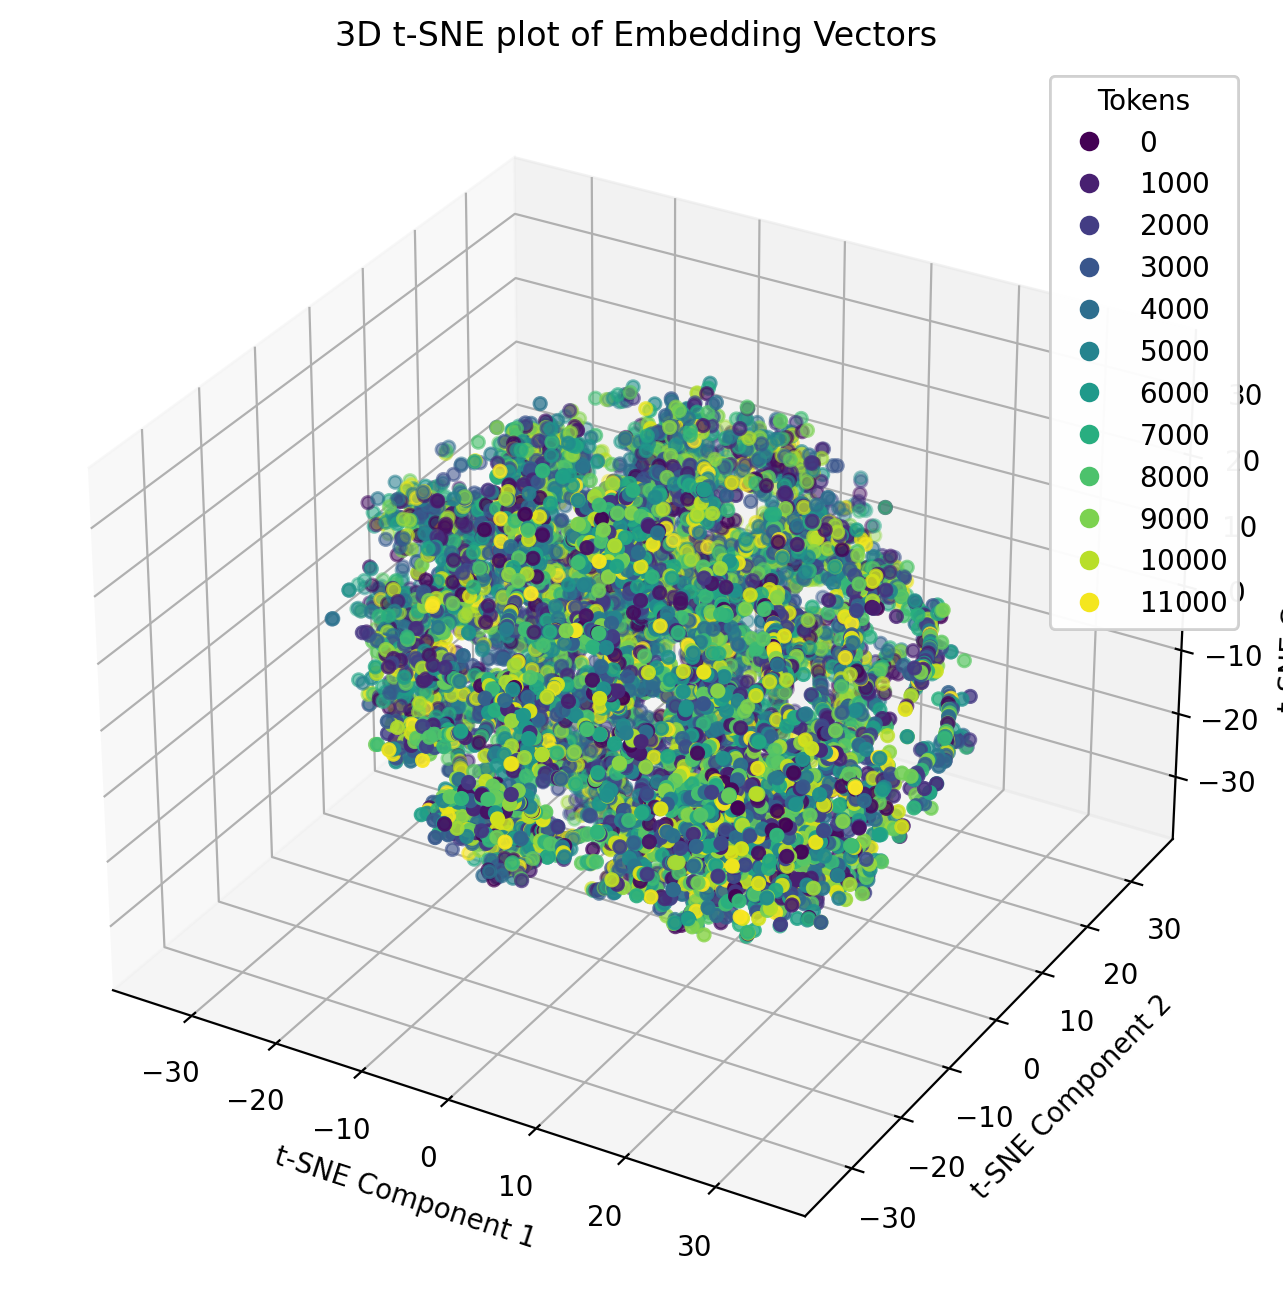

In [25]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [26]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_32_512_r.pth")

In [27]:
model = model.to(device)